<a href="https://colab.research.google.com/github/tsachiblau/sparseGANProject/blob/master/GAN_roy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up

In [171]:
from keras.optimizers import Adam
import numpy as np

np.random.seed(10)
# params
noise_dim = 100
batch_size = 16
half_batch_size = int(batch_size/2)
steps_per_epoch = 3750  # batch_size * steps_per_epoch = epoch size (train size)
epochs = 10
img_rows, img_cols, channels = 28, 28, 1
sparse_dim = img_rows * img_cols * channels
L1_weight = 10   # Loss = data_fidelity + L1_weight * L1_norm
thr_value = 0.1 # x = |x| >= 0.1 ? x : 0

# optimizer - LR and Beta1 are hyper parameters
optimizer = Adam(0.0002,0.5)

train_only_fours = False  # overfit to 4 creation - sanity check
warm_start_discriminator = True # init discriminator by training it *a little bit* as classifier
load_dict = True  #load pretrained dictionary
use_noisy_labels = True # use soft labels and not 0,1 to train
use_reconstructor = True
#
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Mar 15 19:23:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    31W / 250W |   1589MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

import data set

In [129]:
from keras.datasets import mnist
from keras.utils import np_utils
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1

# take only digit 4
x_four_digit = x_train[y_train==4]
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.reshape(-1, img_rows*img_cols*channels) # each image as vector
x_four_digit = x_four_digit.reshape(-1, img_rows*img_cols*channels) # each image as vector
x_test = x_test.reshape(-1, img_rows*img_cols*channels) # each image as vector
np.random.shuffle(x_train)
np.random.shuffle(x_four_digit)
print(x_train.shape)
print(x_four_digit.shape)

(60000, 784)
(5842, 784)


Train/load sparse dictionary:

In [0]:
from sklearn.decomposition import DictionaryLearning
from numpy import loadtxt,savetxt
import matplotlib.pyplot as plt
from google.colab import files


#Train
if(load_dict==False):
  # init a dictionary learning alg - based on LARS
  # TODO - change to all data set and make redundant dictionary
  d=DictionaryLearning(n_components=sparse_dim)
  # train dictionary
  d.fit(x_train)
  dictionary = d.components_
  savetxt('dictionary.csv', dictionary, delimiter=',')
  # download to local machine
  files.download('dictionary.csv') 
  # we will download to a local file named dictionary_loaded
  #*reconstruct* an image for sanity check
  representation_vec = d.transform(x_train[1:2,:])
  print(representation_vec.shape)
  print(dictionary_loaded2.shape)
  dictionary_loaded2 = np.transpose(dictionary_loaded2)
else: #load from file
  dictionary_loaded2 = loadtxt('dictionary_loaded.csv', delimiter=',')
  dictionary_loaded2 = np.array(dictionary_loaded2,dtype=np.float32) # format that is used in keras
  dictionary_loaded2 = np.transpose(dictionary_loaded2)


Sanity test on dictionary

Text(0.5, 1.0, 'Atom example')

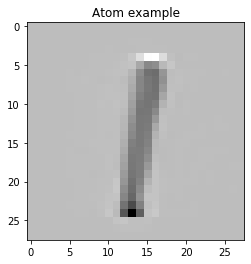

In [0]:
from sklearn.decomposition import DictionaryLearning

atom1 = (dictionary_loaded2)[:,0]
plt.figure()

plt.imshow(atom1.reshape((img_rows, img_cols)), cmap='gray')
plt.title("Atom example")




Other Dict option

In [135]:
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning
import pickle
import os.path
from os import path

#dictionary file name
file_name = 'dictionary15.pkl'

#check if dictionary exists
if not path.exists(file_name):
  sparse_dim = 3000
  d=DictionaryLearning(n_components=sparse_dim, max_iter=10)
  # train dictionary
  d.fit(x_train[1:10000, :])
  dictionary_loaded2 = np.transpose(d.components_)
  print(dictionary.shape)

  with open(file_name, 'wb') as output:
    pickle.dump(d, output, pickle.HIGHEST_PROTOCOL)
  print("created new dictionary")

else:
  with open(file_name, 'rb') as input:
    d = pickle.load(input)
    dictionary_loaded2 = np.transpose(d.components_)
  # print(d)
  print("loaded dictionary")

loaded dictionary


GAN + Reconstructor

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 30s 503us/step - loss: 2.4611 - val_loss: 12.8608
Epoch 2/2
60000/60000 [==============================] - 10s 170us/step - loss: 2.3860 - val_loss: 14.1579
Model: "Gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
init (Dense)                 (None, 256)               25856     
_________________________________________________________________
BN1 (BatchNormalization)     (None, 256)               1024      
_________________________________________________________________
Activation1 (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
hidden1 (Dense)              (None, 512)               131584    
_________________________________________________________________
BN2 (BatchNormalization)     (None, 512)               2048    

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


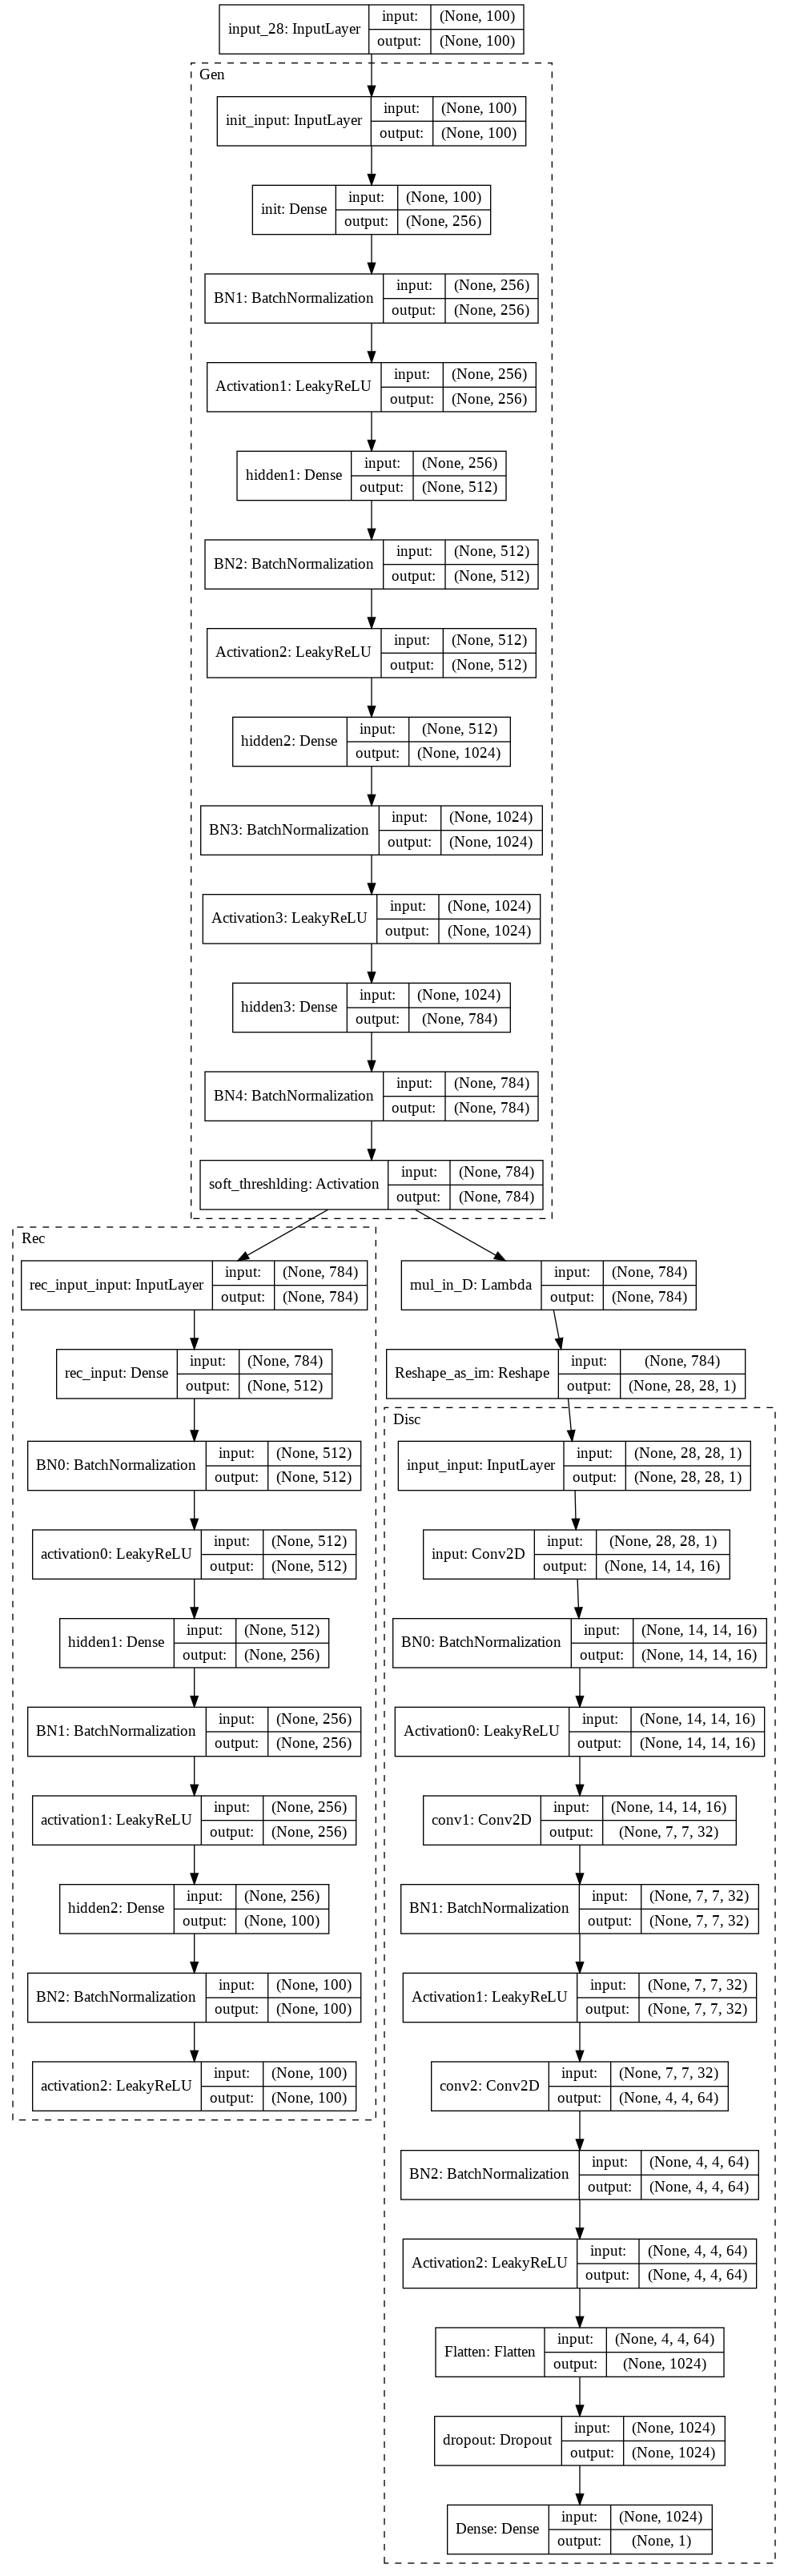

In [172]:
# with pursuit and thresholding approach
from keras.utils import plot_model
from keras.models import Sequential
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal, glorot_uniform
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout,AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda, ReLU, ThresholdedReLU, Activation
from tensorflow.linalg import matmul, matrix_transpose
from tensorflow.math import abs
from keras import regularizers
from keras.losses import kullback_leibler_divergence, binary_crossentropy
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow import cast
from keras.activations import sigmoid
from keras.utils import np_utils

# costum loss - TODO:: parameter to TUNE
def my_loss(y_actual,y_pred):
  #return kullback_leibler_divergence(y_actual,y_pred)
  #return 0.5*(kullback_leibler_divergence(y_actual,y_pred) + binary_crossentropy(y_actual,y_pred))
  return binary_crossentropy(y_actual,y_pred)


# would cause small entries in absulute values to be set to zero and will create sparse vectors
def soft_threshlding(x):
  above_thr_pos = x * cast(x >= thr_value, tf.float32)
  below_thr_neg = x * cast(x <= -thr_value, tf.float32)
  return (above_thr_pos + below_thr_neg)

get_custom_objects().update({'soft_threshlding': Activation(soft_threshlding)})

# input: sparse vec size
# output: noise size
def create_reconstructor():
    reconstructor = Sequential()
    init = RandomNormal(0,stddev=0.02)

    reconstructor.add(Dense(512,  kernel_initializer=init, input_dim=sparse_dim,name="rec_input"))
    reconstructor.add(BatchNormalization(name="BN0"))
    reconstructor.add(LeakyReLU(0.2,name="activation0"))

    reconstructor.add(Dense(256, kernel_initializer=init,name="hidden1"))
    reconstructor.add(BatchNormalization(name="BN1"))
    reconstructor.add(LeakyReLU(0.2,name="activation1"))

    reconstructor.add(Dense(noise_dim, kernel_initializer=init,name="hidden2"))
    reconstructor.add(BatchNormalization(name="BN2"))
    reconstructor.add(LeakyReLU(0.2,name="activation2"))
    return reconstructor

# input: noise size
# output: sparse vec size
def create_generator():
    generator = Sequential()
    init = RandomNormal(0,stddev=0.02)
    generator.add(Dense(256, kernel_initializer=init, input_dim=noise_dim,name="init"))
    generator.add(BatchNormalization(name="BN1"))
    generator.add(LeakyReLU(0.2,name="Activation1"))

    generator.add(Dense(512,kernel_initializer=init,name="hidden1"))
    generator.add(BatchNormalization(name="BN2"))
    generator.add(LeakyReLU(0.2,name="Activation2"))

    generator.add(Dense(1024,kernel_initializer=init,name="hidden2"))
    generator.add(BatchNormalization(name="BN3"))
    generator.add(LeakyReLU(0.2,name="Activation3"))

    generator.add(Dense(sparse_dim, kernel_initializer=init,name="hidden3"))
    # soft thresholding activation
    generator.add(BatchNormalization(name="BN4"))
    generator.add(Activation(soft_threshlding, name='soft_threshlding'))
    return generator

# classifier
def create_trained_classifier():
    classifier = Sequential()
    #16 - better
    classifier.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels),name="input"))
    classifier.add(BatchNormalization(name="BN0"))
    classifier.add(LeakyReLU(0.2,name="Activation0"))
    #32 - better
    classifier.add(Conv2D(32, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv1"))
    classifier.add(BatchNormalization(name="BN1"))
    classifier.add(LeakyReLU(0.2,name="Activation1"))
    # 64 - better
    classifier.add(Conv2D(64, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv2"))
    classifier.add(BatchNormalization(name="BN2"))
    classifier.add(LeakyReLU(0.2,name="Activation2"))
    
    classifier.add(Flatten(name="Flatten"))
    classifier.add(Dropout(0.4,name="dropout"))
    classifier.add(Dense(10, activation='softmax',kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="Dense"))   # 1 number which indicates real / fake
    classifier.trainable = True
    classifier.compile(loss='categorical_crossentropy', optimizer=optimizer)

    model=classifier.fit(x_train.reshape(-1,img_rows,img_cols,channels), y_train, 
                              validation_data=(x_test.reshape(-1,img_rows,img_cols,channels), y_test), epochs=2, batch_size=64)
    return classifier
# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_descriminator():
    if(warm_start_discriminator):
      classifier = create_trained_classifier()
      classifier.pop()
      classifier.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="Dense"))   # 1 number which indicates real / fake
      classifier.trainable = True
      classifier.compile(loss='binary_crossentropy', optimizer=optimizer)
      return classifier
    else:
      discriminator = Sequential()
      #16 - better
      discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels),name="input"))
      discriminator.add(BatchNormalization(name="BN0"))
      discriminator.add(LeakyReLU(0.2,name="Activation0"))
      #32 - better
      discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv1"))
      discriminator.add(BatchNormalization(name="BN1"))
      discriminator.add(LeakyReLU(0.2,name="Activation1"))
      # 64 - better
      discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv2"))
      discriminator.add(BatchNormalization(name="BN2"))
      discriminator.add(LeakyReLU(0.2,name="Activation2"))
      
      discriminator.add(Flatten(name="Flatten"))
      discriminator.add(Dropout(0.4,name="dropout"))
      discriminator.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="Dense"))   # 1 number which indicates real / fake
      discriminator.trainable = True
      discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
      return discriminator

# build GAN
discriminator = create_descriminator()
generator = create_generator()
reconstructor = create_reconstructor()
# naming:
discriminator.name = "Disc"
generator.name = "Gen"
reconstructor.name = "Rec"
#
discriminator.trainable = False   # will be trained separately, not as GAN

gan_input = Input(shape=(noise_dim,))

# G(z) is a sparse vector
sparse_vec = generator(gan_input)   # sparse_dim size - it is thresholded

# a layer that creates the multiplication between the sparse tensor with dictionary to create image
fake_image_vec = Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D')(sparse_vec)
# reshape to image size - will be inserted to discriminator
fake_image = Reshape((img_rows, img_cols, channels),name="Reshape_as_im")(fake_image_vec)

gan_output = discriminator(fake_image)  # the descriminator output
vae_output = reconstructor(sparse_vec)  # the reconstructor output

vae = Model(gan_input, vae_output)
vae.compile(loss='mean_squared_error', optimizer='sgd')

# todo - double output double loss
gan = Model(gan_input, [gan_output,sparse_vec])
gan.compile(loss=[my_loss,'mean_absolute_error'], optimizer=optimizer,loss_weights=[1,L1_weight])

print(generator.summary())
print(discriminator.summary())
print(reconstructor.summary())
complete = Model(gan_input,[gan_output,vae_output])
plot_model(complete, to_file='model_plot.png', show_shapes=True, show_layer_names=True,expand_nested=True)


Sanity check predicted values

In [139]:
noise = np.random.normal(0, 1, size=(half_batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
gan_pred = gan.predict(noise)[0]
print("gan pred = "+str(np.average(gan_pred)))

fake_x = generator.predict(noise) # create G(z)

fake_x = np.transpose(fake_x)
# multiply by dict
fake_x = np.matmul(dictionary_loaded2,fake_x)

fake_x = np.transpose(fake_x)
fake_x = fake_x.reshape(half_batch_size,img_rows,img_cols,channels)

d_pred = discriminator.predict(fake_x)
print("d_pred pred = "+str(np.average(d_pred)))

gan pred = 0.49397507
d_pred pred = 0.49397507


Train the GAN

init loss is 0.8006475 and should be around 1
results after iter  0  d_fake_as_real =  0.29257516860961913  d_real_as_real  0.9618602395057678  support =  0.0


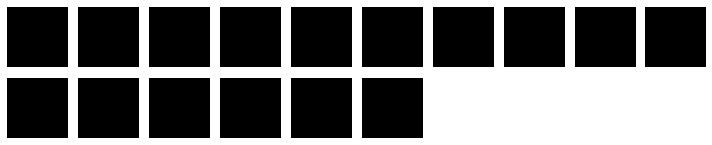

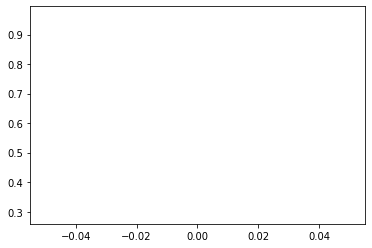

results after iter  1000  d_fake_as_real =  0.027081909279028576  d_real_as_real  0.038887202739715576  support =  596.625


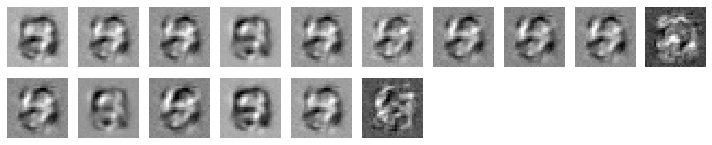

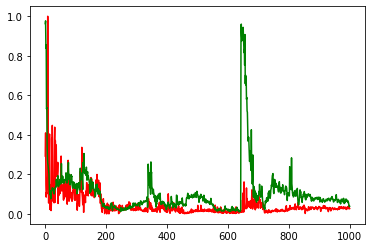

results after iter  2000  d_fake_as_real =  0.06412338752012986  d_real_as_real  0.06279924511909485  support =  327.6875


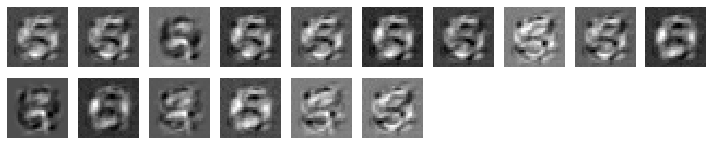

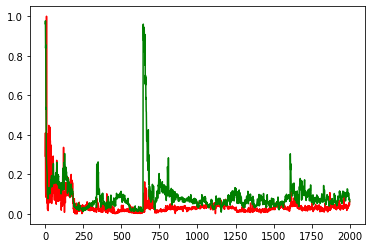

results after iter  3000  d_fake_as_real =  0.03747099041938782  d_real_as_real  0.1474038561185201  support =  221.375


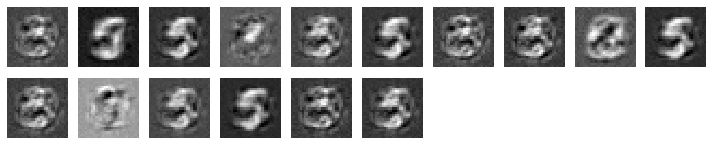

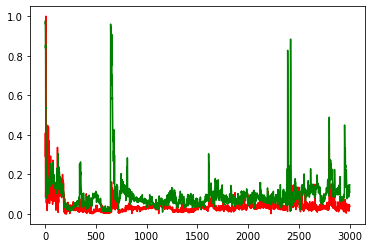

Epoch: 0 	 Discriminator Loss_fake: 0.19501249492168427 	 Discriminator Loss_real: 0.10568951070308685		 Generator Loss: [4.6603756, 2.4949949, 0.21529436]


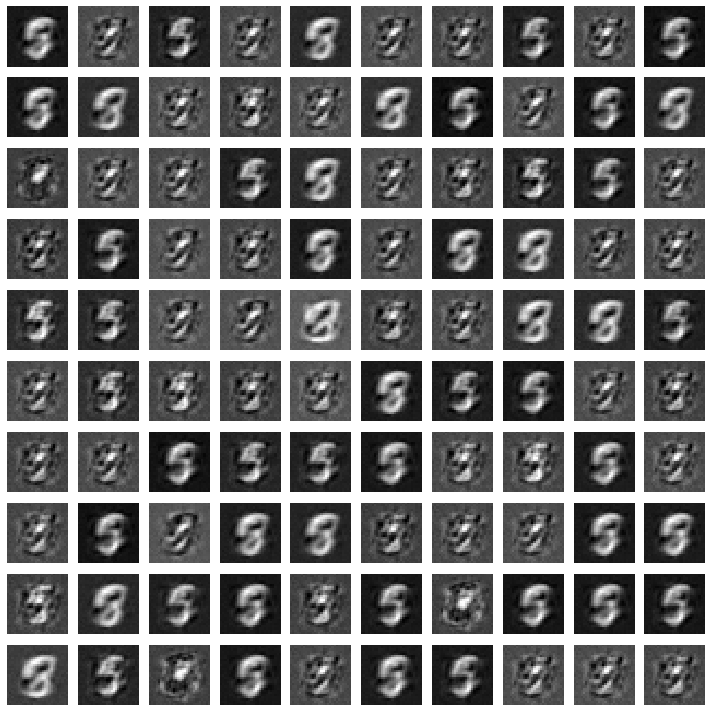

results after iter  4000  d_fake_as_real =  0.021819797429171475  d_real_as_real  0.11119661331176758  support =  205.875


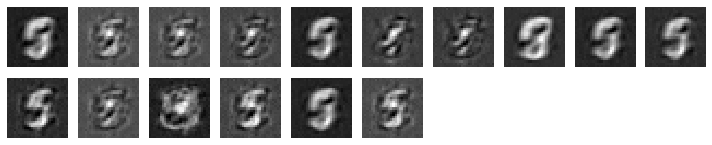

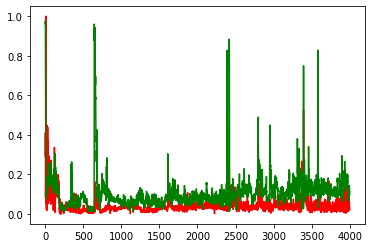

results after iter  5000  d_fake_as_real =  0.013339700798193613  d_real_as_real  0.08081629127264023  support =  310.125


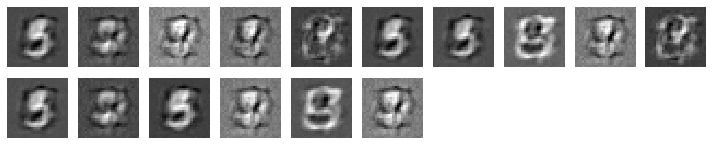

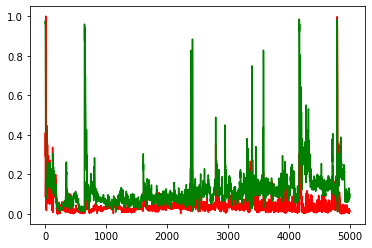

results after iter  6000  d_fake_as_real =  0.03318288109519265  d_real_as_real  0.20428059101104737  support =  253.75


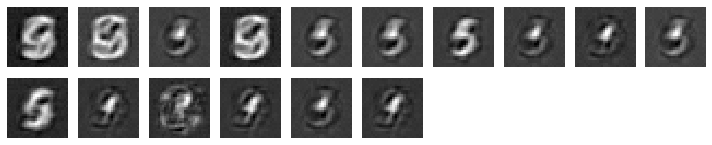

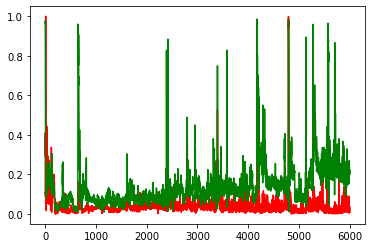

results after iter  7000  d_fake_as_real =  0.0653047243754069  d_real_as_real  0.303655207157135  support =  235.75


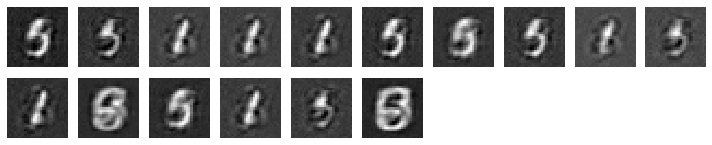

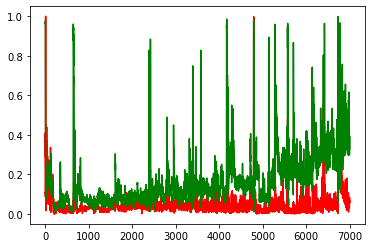

Epoch: 1 	 Discriminator Loss_fake: 0.2044537216424942 	 Discriminator Loss_real: 0.20144429802894592		 Generator Loss: [4.2671394, 2.3295507, 0.19171461]


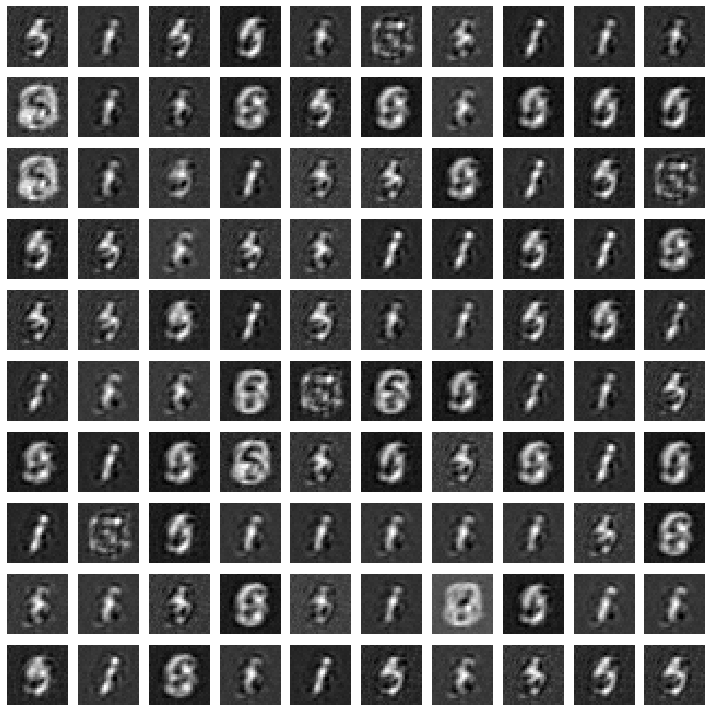

results after iter  8000  d_fake_as_real =  0.06896402438481648  d_real_as_real  0.3281987054007394  support =  219.6875


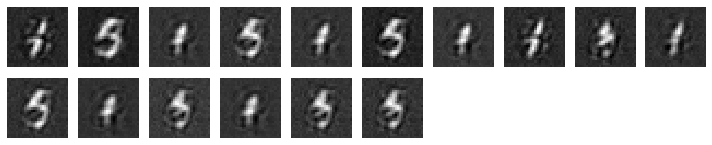

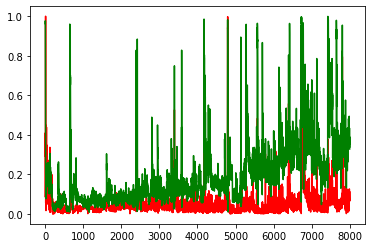

results after iter  9000  d_fake_as_real =  0.13872724229639227  d_real_as_real  0.4069183349609375  support =  288.375


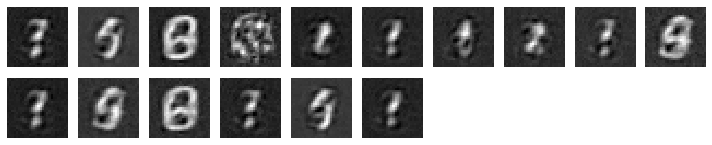

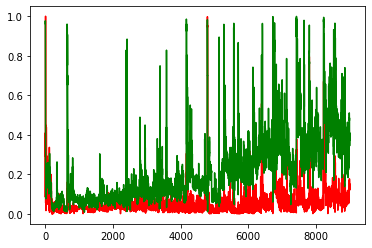

results after iter  10000  d_fake_as_real =  0.2216610312461853  d_real_as_real  0.8073322772979736  support =  275.5


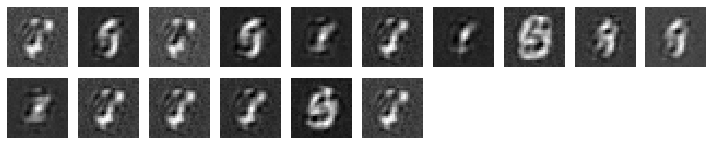

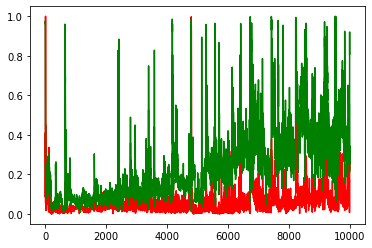

results after iter  11000  d_fake_as_real =  0.14390918016433715  d_real_as_real  0.4550712325356223  support =  275.9375


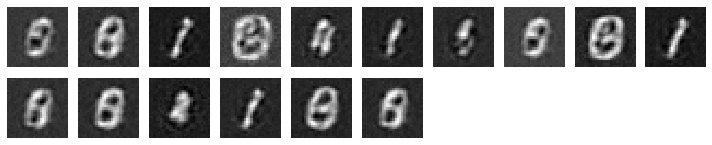

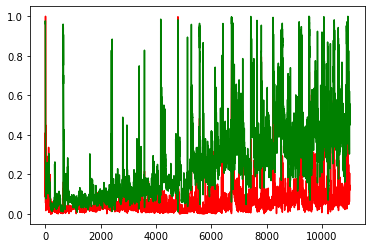

Epoch: 2 	 Discriminator Loss_fake: 0.20017583668231964 	 Discriminator Loss_real: 0.22264359891414642		 Generator Loss: [4.8369994, 2.6237838, 0.21886805]


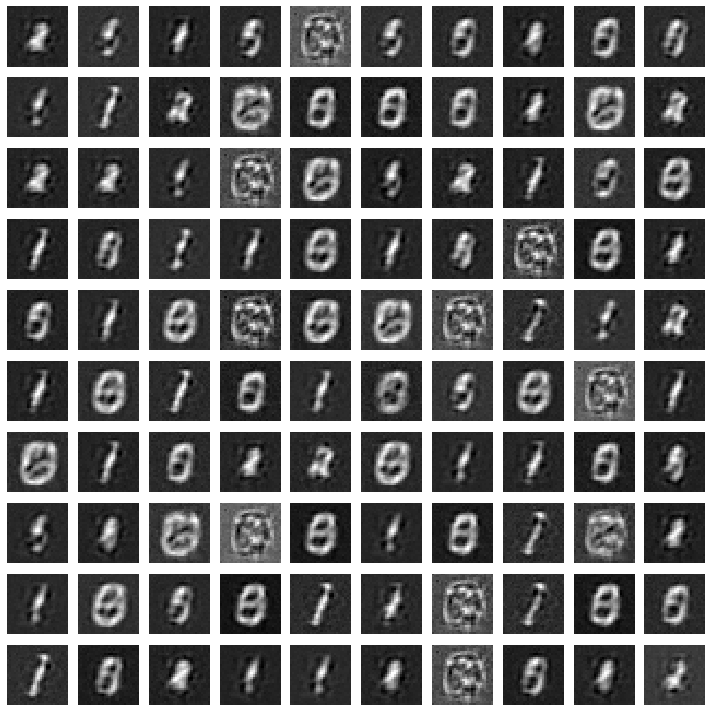

results after iter  12000  d_fake_as_real =  0.06404801458120346  d_real_as_real  0.3447321483067104  support =  313.0625


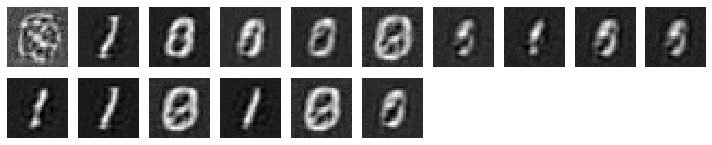

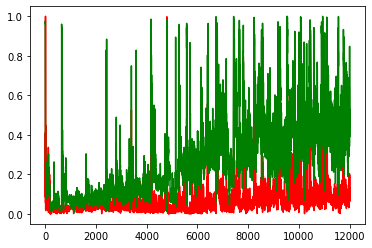

results after iter  13000  d_fake_as_real =  0.08302896469831467  d_real_as_real  0.317069947719574  support =  260.125


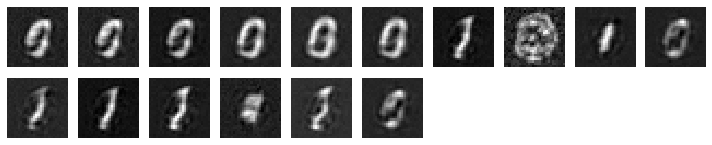

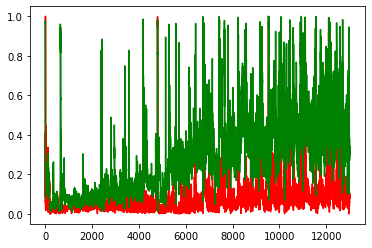

results after iter  14000  d_fake_as_real =  0.09017893075942993  d_real_as_real  0.380035400390625  support =  261.8125


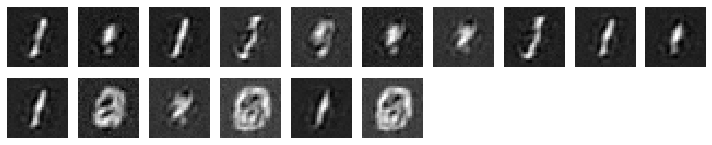

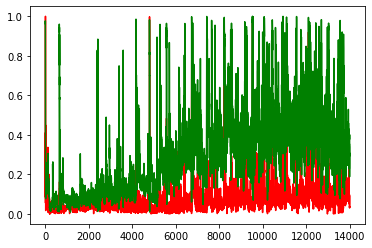

Epoch: 3 	 Discriminator Loss_fake: 0.26583659648895264 	 Discriminator Loss_real: 0.24529126286506653		 Generator Loss: [4.1417165, 2.3778896, 0.1743059]


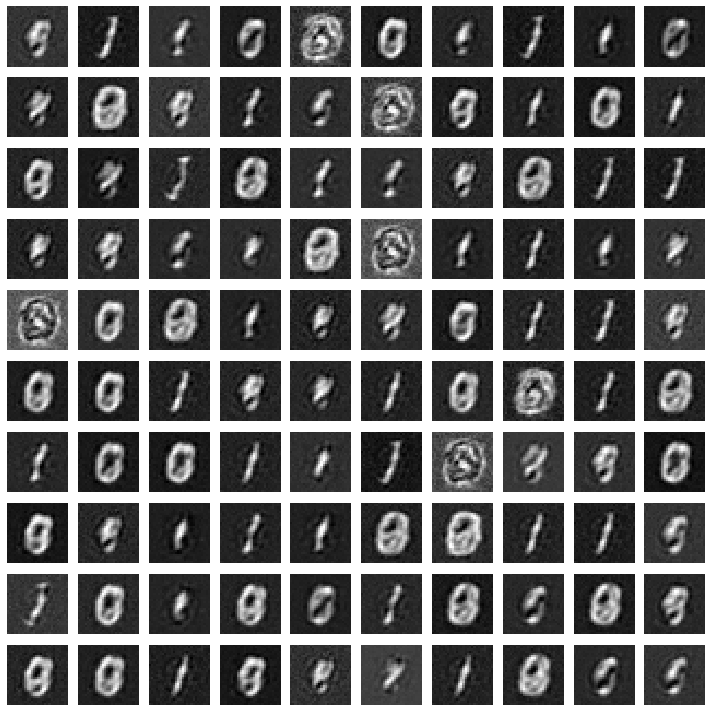

results after iter  15000  d_fake_as_real =  0.07774411638577779  d_real_as_real  0.22682878971099854  support =  377.625


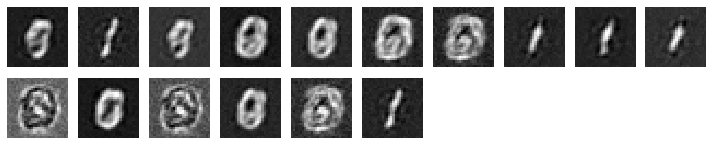

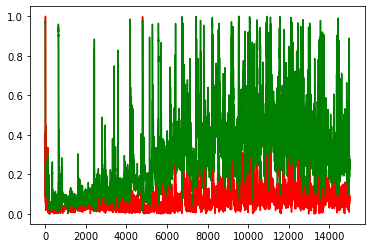

results after iter  16000  d_fake_as_real =  0.06599212437868118  d_real_as_real  0.29124025503794354  support =  263.5


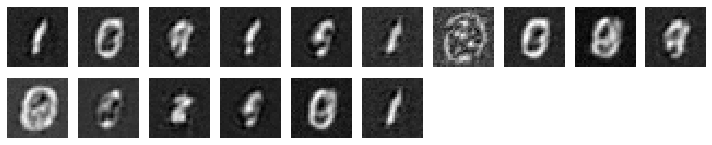

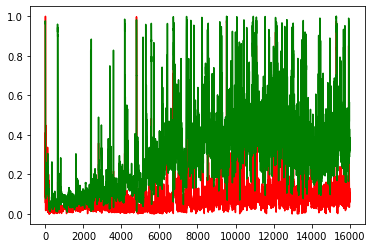

results after iter  17000  d_fake_as_real =  0.05885210633277893  d_real_as_real  0.29791661103566486  support =  263.375


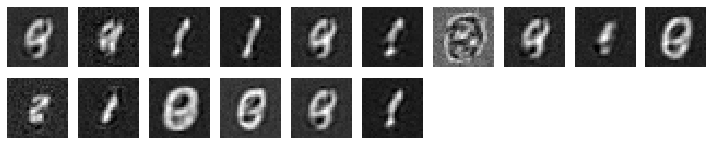

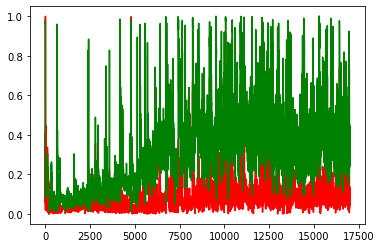

results after iter  18000  d_fake_as_real =  0.08283519744873047  d_real_as_real  0.2706894874572754  support =  214.75


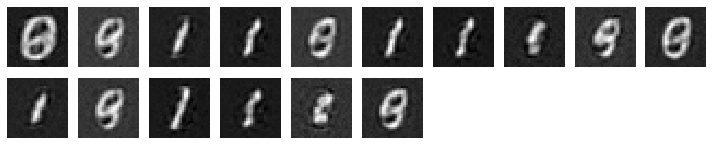

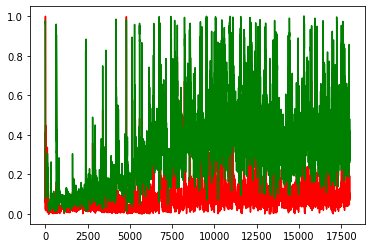

Epoch: 4 	 Discriminator Loss_fake: 0.2449546903371811 	 Discriminator Loss_real: 0.09960519522428513		 Generator Loss: [3.9739444, 2.3157907, 0.16366929]


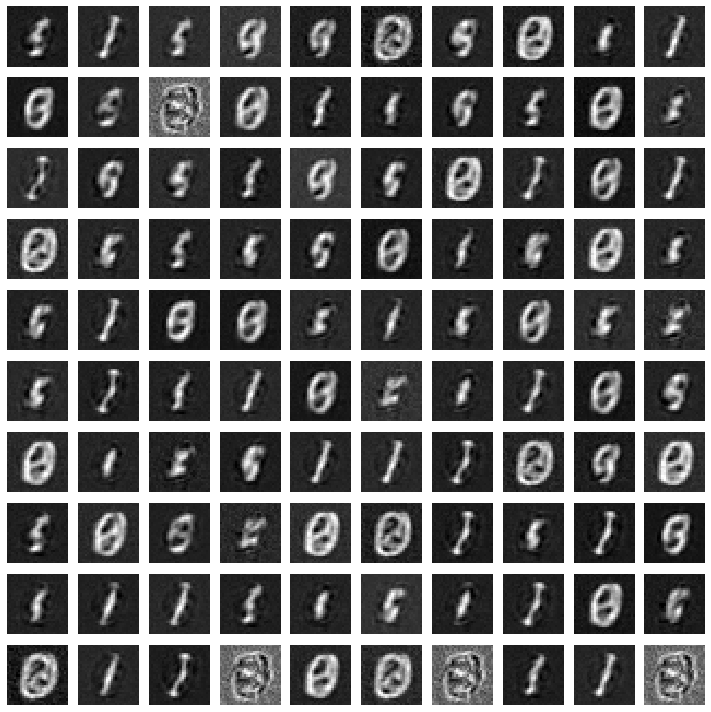

results after iter  19000  d_fake_as_real =  0.8513998985290527  d_real_as_real  0.9966007073720297  support =  213.6875


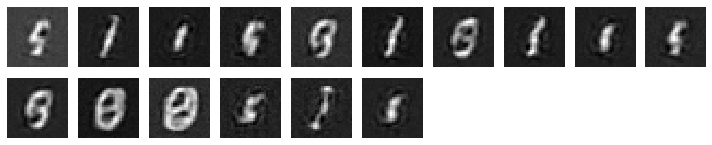

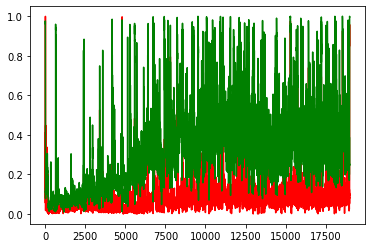

results after iter  20000  d_fake_as_real =  0.06564543247222901  d_real_as_real  0.3774450042031028  support =  335.5625


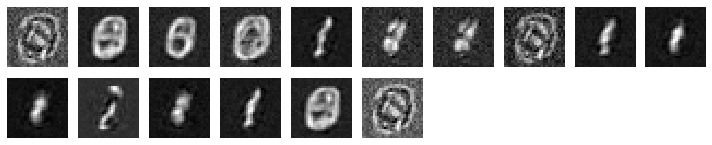

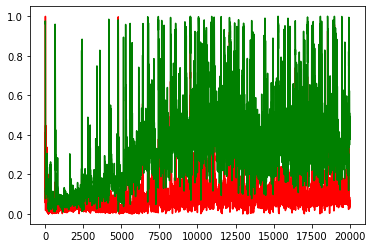

results after iter  21000  d_fake_as_real =  0.11243402106421334  d_real_as_real  0.21767833828926086  support =  304.5625


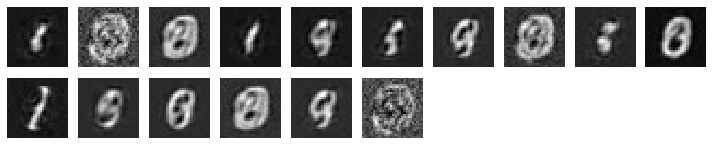

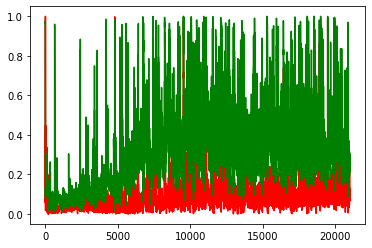

results after iter  22000  d_fake_as_real =  0.14752807219823202  d_real_as_real  0.5083756446838379  support =  244.3125


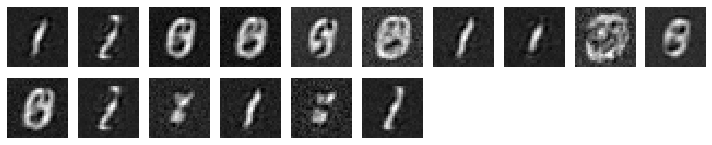

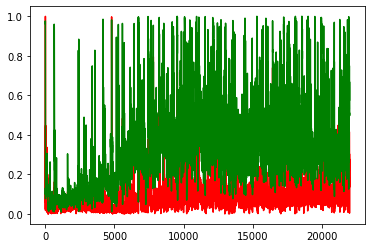

Epoch: 5 	 Discriminator Loss_fake: 0.2201506495475769 	 Discriminator Loss_real: 0.36483505368232727		 Generator Loss: [4.2831607, 2.6113515, 0.16452777]


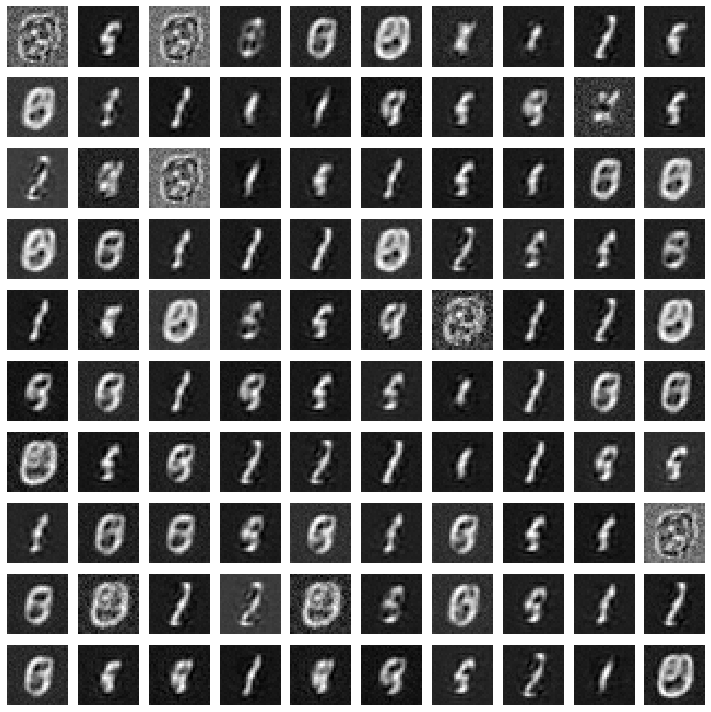

results after iter  23000  d_fake_as_real =  0.08748293839968167  d_real_as_real  0.3588939110438029  support =  220.375


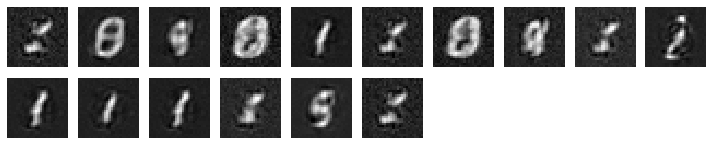

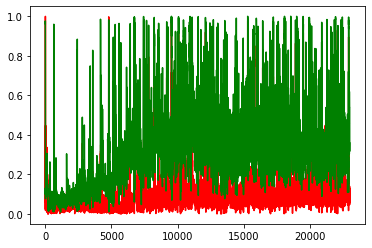

In [0]:
import matplotlib.pyplot as plt
from numpy.random import uniform
# sanity check - overfit on 4 digit
if(train_only_fours):
  x_train = x_four_digit


# training G and D same amount of times - D should be train on fake and real half
n_d = 1
n_g = 1
n_r = 1

# count the number of non-zeros
def count_support(sparse_mat):
  return (np.count_nonzero(sparse_mat))/sparse_mat.shape[0]

# plots 100 images generated by the Generator
def show_images(noise):
    generated_images = generator.predict(noise)
    generated_images = np.matmul(dictionary_loaded2,np.transpose(generated_images))
    generated_images = np.transpose(generated_images)
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()



def stop_criteria(fake_x,fake_as_real,real_as_real):
  return np.average(fake_as_real)>=0.49 and (np.abs(np.average(fake_as_real) - np.average(real_as_real))<= 0.05)

def d_ratio_on_fake(fake_x):
  return np.sum(discriminator.predict(fake_x))/fake_x.shape[0]

def d_ratio_on_real(real_x):
  return np.sum(discriminator.predict(real_x))/real_x.shape[0]

fake_as_real = np.array([])
real_as_real = np.array([])
iters= np.array([])
stop = False
fake_x = 0
g_loss = 0
count_reaches=0

for epoch in range(10):  #epochs
    for iter in range(int(steps_per_epoch)):
      i = iter + int(epoch*(steps_per_epoch))
    # train D
      for batch in range(n_d):  #steps_per_epoch
          # stochastic size of real and fake batches
          stoch_batch_size = int(np.random.uniform(1,batch_size))

          noise = np.random.normal(0, 1, size=(stoch_batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
          fake_x = generator.predict(noise) # create G(z)
          # fake is (stoch_batch_size,sparse_dim)
          
          fake_x = np.transpose(fake_x)
          # multiply by dict
          fake_x = np.matmul(dictionary_loaded2,fake_x)

          fake_x = np.transpose(fake_x)
          fake_x = fake_x.reshape(stoch_batch_size,img_rows,img_cols,channels)
          # fake_x is of size (stoch_batch_size,rows,cols,channels)

          real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size-stoch_batch_size)] # sample real image
          #remove below to return to FC scheme
          real_x = real_x.reshape(batch_size-stoch_batch_size,img_rows,img_cols,channels)

          #x = np.concatenate((real_x, fake_x))
          
          disc_y = np.zeros(batch_size)
          disc_y[stoch_batch_size:] = 0.9
          # [0 ... 0.9 ...]
          y_real =  disc_y[stoch_batch_size:]
          y_fake = disc_y[:stoch_batch_size]
          if(use_noisy_labels):
            y_real = np.random.uniform(0.9,1,batch_size-stoch_batch_size)
            y_fake = np.random.uniform(0,0.1,stoch_batch_size)

          # train_on_batch recieves data and desired output
          discriminator.trainable = True
          d_loss_real = discriminator.train_on_batch(real_x, y_real)
          d_loss_fake = discriminator.train_on_batch(fake_x, y_fake)
          discriminator.trainable = False
          # sanity check loss - should be 0.5
          if(epoch==0 and batch==0 and iter ==0):
            print("init loss is "+ str(d_loss_real)+" and should be around 1")
          # check stop criteria
          if(epoch>=1 and stop_criteria(fake_x,fake_as_real[-100:],real_as_real[-100:])):
            print("converged in epoch "+str(epoch))
            print("d_ratio_on_fake(fake_x): ",d_ratio_on_fake(fake_x))
            show_images(noise)
            count_reaches += 1
            stop = True
            break
      if(stop):
        break
      # print temp results
      fake_as_real = np.append(fake_as_real,d_ratio_on_fake(fake_x))
      iters =  np.append(iters,i)
      real_as_real = np.append(real_as_real,d_ratio_on_real(real_x))
      if(i%1000==0):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        print("results after iter ",i," d_fake_as_real = ",d_ratio_on_fake(fake_x)," d_real_as_real ",d_ratio_on_real(real_x)," support = " ,count_support(generator.predict(noise)))
        show_images(noise)
        plt.plot(iters,fake_as_real,'r')
        plt.plot(iters,real_as_real,'g')
        plt.show()
      # train G
      for batch in range(n_g):  #steps_per_epoch
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        # train GAN (descriminator weights are fixed)
        y_gen_1 = np.ones(batch_size)
        if(use_noisy_labels==True):
          y_gen_1 = np.random.uniform(0.9,1,batch_size)
        y_gen_2 = np.zeros(batch_size * sparse_dim)
        y_gen_2 = y_gen_2.reshape(batch_size,sparse_dim)
        # TODO train the two outputs
        g_loss = gan.train_on_batch(noise, [y_gen_1,y_gen_2])
            
      # train R
      if(use_reconstructor):
        for batch in range(n_r):  #steps_per_epoch
          noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
          r_loss = vae.train_on_batch(noise[:batch_size],noise[:batch_size])

    if(stop):
        break
    print(f'Epoch: {epoch} \t Discriminator Loss_fake: {d_loss_fake} \t Discriminator Loss_real: {d_loss_real}\t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(100, noise_dim))
    show_images(noise)







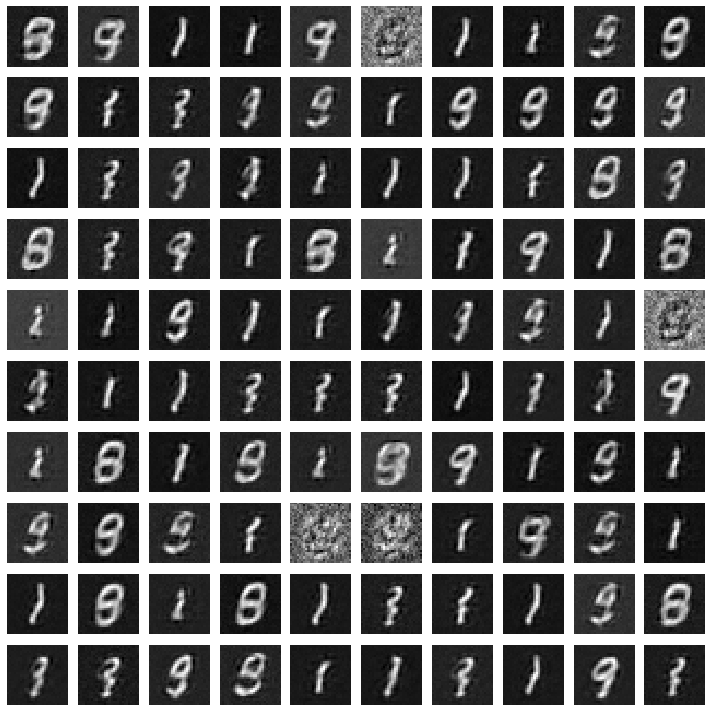

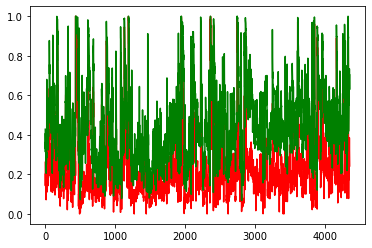

In [165]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)
plt.plot(iters,fake_as_real,'r')
plt.plot(iters,real_as_real,'g')
plt.show()


Trying WGAN - define + train


(6265, 28, 28, 1)


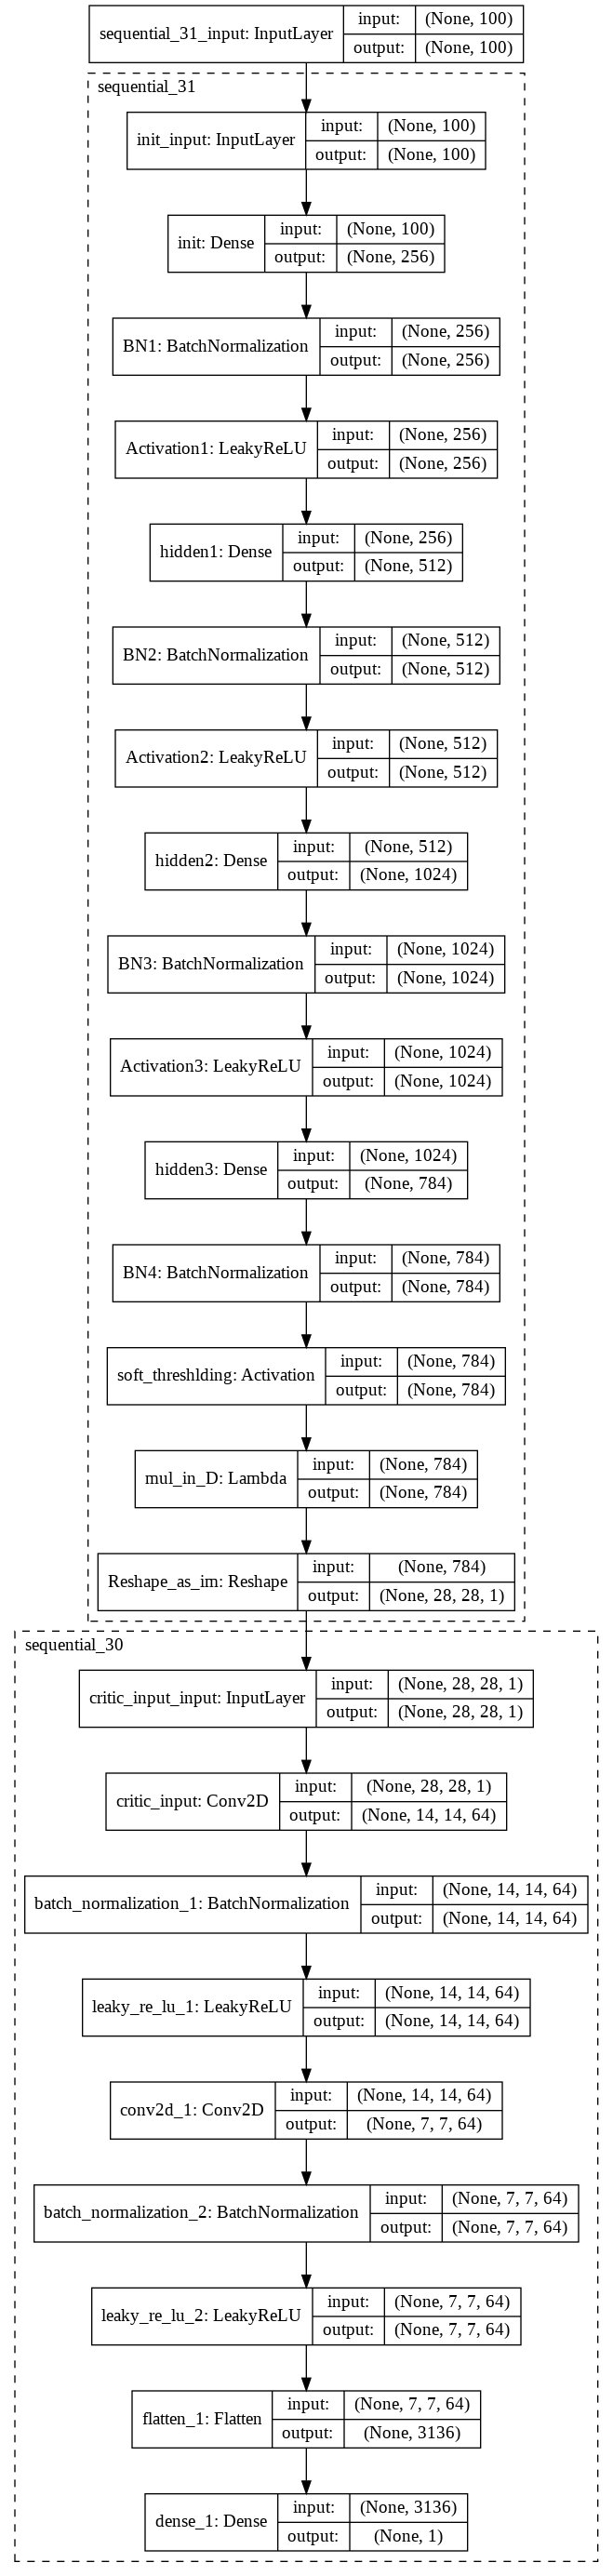

In [71]:
# example of a wgan for generating handwritten digits
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda, ReLU, ThresholdedReLU, Activation
from tensorflow.linalg import matmul, matrix_transpose
from tensorflow.math import abs
from keras import regularizers
from keras.losses import kullback_leibler_divergence, binary_crossentropy
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow import cast
from keras.utils import plot_model


# would cause small entries in absulute values to be set to zero and will create sparse vectors
def soft_threshlding(x):
  above_thr_pos = x * cast(x >= thr_value, tf.float32)
  below_thr_neg = x * cast(x <= -thr_value, tf.float32)
  return (above_thr_pos + below_thr_neg)

get_custom_objects().update({'soft_threshlding': Activation(soft_threshlding)})

# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape,name="critic_input"))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1))
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model


# input: noise size
# output: sparse vec size
def define_generator(latent_dim):
    generator = Sequential()
    init = RandomNormal(0,stddev=0.02)
    generator.add(Dense(256, kernel_initializer=init, input_dim=latent_dim,name="init"))
    generator.add(BatchNormalization(name="BN1"))
    generator.add(LeakyReLU(0.2,name="Activation1"))

    generator.add(Dense(512,kernel_initializer=init,name="hidden1"))
    generator.add(BatchNormalization(name="BN2"))
    generator.add(LeakyReLU(0.2,name="Activation2"))

    generator.add(Dense(1024,kernel_initializer=init,name="hidden2"))
    generator.add(BatchNormalization(name="BN3"))
    generator.add(LeakyReLU(0.2,name="Activation3"))

    generator.add(Dense(sparse_dim, kernel_initializer=init,name="hidden3"))
    # soft thresholding activation
    generator.add(BatchNormalization(name="BN4"))
    generator.add(Activation(soft_threshlding, name='soft_threshlding'))
    # from generator to critic we need to multiply by dictionary and reshape as an image
    generator.add(Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D'))
    # reshape to image size - will be inserted to discriminator
    generator.add(Reshape((img_rows, img_cols, channels),name="Reshape_as_im"))
    return generator

# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
  # make weights in the critic not trainable
  critic.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(generator)
  # add the critic
  model.add(critic)
  # compile model
  opt = RMSprop(lr=0.00005)
  model.compile(loss=wasserstein_loss, optimizer=opt)
  return model

# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# select all of the examples for a given class
	selected_ix = trainy == 7
	X = trainX[selected_ix]
	# expand to 3d, e.g. add channels
	X = expand_dims(X, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.savefig('plot_line_plot_loss.png')
	pyplot.close()

# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=40, n_batch=64, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(mean(c1_tmp))
		c2_hist.append(mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
		# summarize loss on this batch
		print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
		# evaluate the model performance every 'epoch'
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist)

# size of the latent space
latent_dim = 100
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# visualize model
plot_model(gan_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,expand_nested=True)


In [0]:
# train model
train(generator, critic, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, c1=-2.168, c2=0.000 g=-0.814


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>2, c1=-6.284, c2=0.632 g=-0.413
>3, c1=-8.687, c2=-0.210 g=0.051
>4, c1=-10.386, c2=-0.947 g=0.600
>5, c1=-11.951, c2=0.331 g=0.899
>6, c1=-13.269, c2=-1.427 g=1.259
>7, c1=-14.694, c2=-2.138 g=1.691
>8, c1=-16.017, c2=-1.328 g=2.172
>9, c1=-16.786, c2=-1.071 g=2.645
>10, c1=-18.127, c2=-1.469 g=3.113
>11, c1=-18.712, c2=-1.768 g=3.421
>12, c1=-19.104, c2=-1.268 g=3.905
>13, c1=-20.121, c2=-2.183 g=4.391
>14, c1=-20.696, c2=-1.466 g=4.663
>15, c1=-21.659, c2=-2.002 g=5.320
>16, c1=-21.261, c2=-1.605 g=5.950
>17, c1=-22.730, c2=-3.930 g=6.203
>18, c1=-23.294, c2=-3.155 g=6.781
>19, c1=-23.190, c2=-4.222 g=7.319
>20, c1=-24.219, c2=-3.974 g=7.698
>21, c1=-24.534, c2=-4.506 g=8.092
>22, c1=-25.012, c2=-4.400 g=8.618
>23, c1=-24.829, c2=-4.239 g=9.239
>24, c1=-25.466, c2=-5.530 g=9.747
>25, c1=-26.862, c2=-6.831 g=10.310
>26, c1=-26.044, c2=-6.426 g=10.783
>27, c1=-27.402, c2=-6.902 g=11.048
>28, c1=-27.667, c2=-8.581 g=11.534
>29, c1=-28.325, c2=-7.073 g=11.819
>30, c1=-28.954, c2=-6.896